# Load the Packages

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import missingno
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
from collections import Counter
from nltk.tokenize import word_tokenize

# Load Data

In [5]:
# load the data
DATA_PATH = r"C:/Users/Sagar Nikam/Downloads/reddit-sentiment-analysis-main/reddit-sentiment-analysis-main/data/reddit.csv"
df = pd.read_csv(DATA_PATH)

df

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [43]:
# rename columns

df.rename({"clean_comment":"comment",
           "category":"sentiment"},axis=1,inplace=True)

In [44]:
# missing data

df.isna().sum()

comment      100
sentiment      0
dtype: int64

**There are 100 missing values in the comment**

<Axes: >

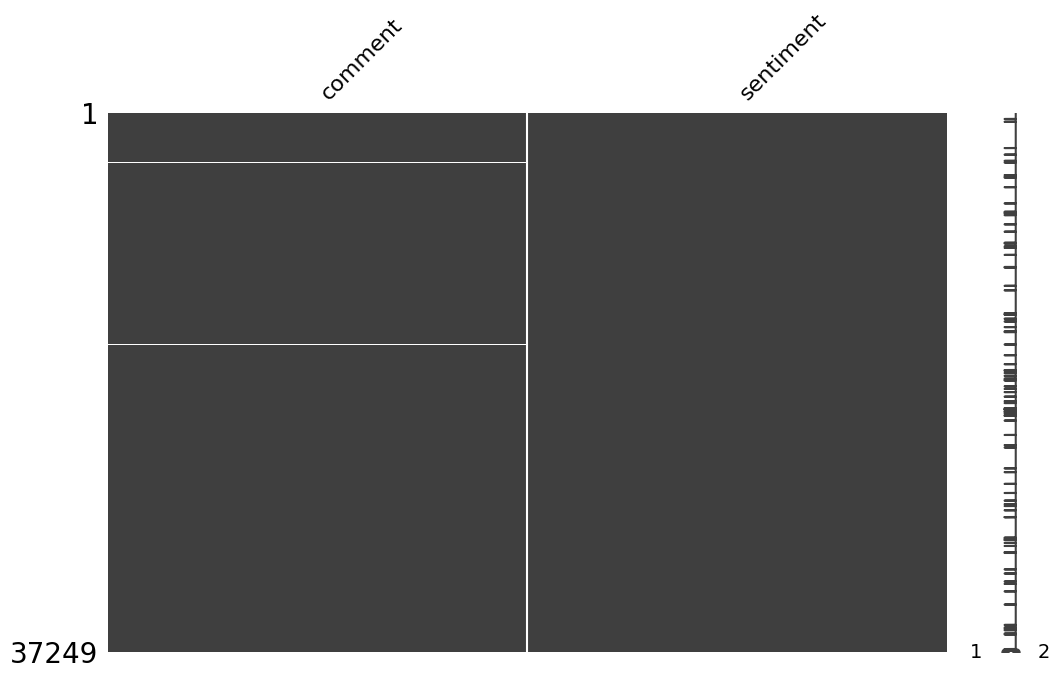

In [45]:
# missing values matrix

missingno.matrix(df,figsize=(12,7))

In [46]:
# rows that have missing values

(
    df.loc[
        df['comment'].isna()
    ]
)

,comment,sentiment
413,NaN,0
605,NaN,0
2422,NaN,0
2877,NaN,0
3307,NaN,0
...,...,...
35975,NaN,0
36036,NaN,0
37043,NaN,0
37111,NaN,0


In [47]:
# sentiment of rows that have missing values

(
    df.loc[
        df['comment'].isna(),"sentiment"
    ]
    .value_counts()
)

sentiment
0    100
Name: count, dtype: int64

**All rows that have missing values have been labelled the sentiment of 0 (neutral)**

In [48]:
# check for duplicate comments in the data

print(df['comment'].dropna().duplicated().sum())

350


**`350` comments in the data are duplicated**

In [49]:
# shape of the data

data_rows, data_cols = df.shape
print(f'The data has {data_rows} rows and {data_cols} columns')

The data has 37249 rows and 2 columns


In [50]:
# comments having words like modi,bjp and congress

(
    df
    .dropna()
    .loc[(lambda df_: df_['comment'].str.contains(r"bjp|congress|modi")),"comment"]
)

51        tea partier expresses support for namo after ...
68           can congress eliminate namo and blame advani 
69        don know but surely there his statue every bj...
70       after seeing this uvjx3kwoehw video seems anyt...
72       congress needs bogeyman modi without the bad g...
                               ...                        
37210                                      modi april fool
37228    also modiji will give award ravish kumar tonight 
37236     fan modi but some the best people ever met li...
37245    kya bhai pure saal chutiya banaya modi aur jab...
37248               facebook itself now working bjp’ cell 
Name: comment, Length: 7055, dtype: object

In [51]:
# distribution of such comments

print(
      df['comment']
      .dropna()
      .str.contains(r"bjp|congress|modi")
      .mean() * 100
    )

18.991089935126112


# Data Cleaning

In [52]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\Sagar
[nltk_data]     Nikam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sagar
[nltk_data]     Nikam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
len(df.loc[14037,'comment'].split())

2

In [54]:
def remove_whitespaces(ser):
    return ser.str.lstrip().str.rstrip()

def count_words(text):
    return len(text.split(" "))

def removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    return text

def removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def clean_text(text):
    text = removing_numbers(text)
    text = removing_punctuations(text)
    text = removing_urls(text)
    return text

def sentence_length(ser):
    bins = [0,10, 25, 50, ser.max()]
    labels = ['Short', 'Medium', 'Long', 'Very Long']
    return pd.cut(ser,bins=bins,labels=labels)

def is_response(ser):
    return np.where(ser <= 3, 1, 0)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

def lemmatize(text):
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text.split(" ")]
    return " ".join(text)


In [55]:
def remove_emoji(text):
    # Regex pattern to match all emoji characters
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
        u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and pictographs extended-A
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_non_ascii(text):
    # Remove all non-ASCII characters
    return re.sub(r'[^\x00-\x7F]+', '', text)

def remove_chinese(text):
    # Regex to remove Chinese characters (CJK Unified Ideographs)
    return re.sub(r'[\u4e00-\u9fff]+', '', text)

def clean_unicode_text(text):
    # Apply all cleaning functions
    text = remove_emoji(text)
    text = remove_chinese(text)
    text = remove_non_ascii(text)
    return text

In [56]:
df['comment'].dropna().apply(count_words)

0         41
1        197
2         87
3         30
4        113
        ... 
37244      1
37245     19
37246      8
37247      3
37248      7
Name: comment, Length: 37149, dtype: int64

In [57]:
def count_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Define POS categories
    nouns = ['NN', 'NNS', 'NNP', 'NNPS']
    verbs = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    adjectives = ['JJ', 'JJR', 'JJS']

    # Count the POS tags
    pos_counts = Counter(tag for word, tag in pos_tags)

    num_nouns = sum(pos_counts[pos] for pos in nouns)
    num_verbs = sum(pos_counts[pos] for pos in verbs)
    num_adjectives = sum(pos_counts[pos] for pos in adjectives)
    return pd.Series({'nouns': num_nouns, 'verbs': num_verbs, 'adjectives': num_adjectives})

In [58]:
def clean_data(data):

    return (
        data
        .dropna()
        .drop_duplicates(subset=['comment'])
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].str.lstrip().str.rstrip().str.lower(),
            word_count = lambda df_: df_.loc[:,"comment"].apply(count_words),
            named_sentiment = lambda df_: df_.loc[:,"sentiment"].replace({0:"neutral",
                                                                         -1:"negative",
                                                                          1:"positive"}),
            sentence_length = lambda df_: df_.loc[:,"word_count"].pipe(sentence_length),
            response = lambda df_: df_.loc[:,"word_count"].pipe(is_response)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(removing_punctuations)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(clean_unicode_text)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(remove_stopwords)
        )
        .assign(
            comment = lambda df_: df_.loc[:,"comment"].apply(lemmatize)
        )
        .loc[lambda df_: ~(df_['comment'].str.contains(r"bjp|congress|modi")),:]
    )

In [59]:
final_df = clean_data(df)

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\Sagar Nikam/nltk_data'
    - 'd:\\Influencer-Insights-Chrome-Plugin\\.venv\\nltk_data'
    - 'd:\\Influencer-Insights-Chrome-Plugin\\.venv\\share\\nltk_data'
    - 'd:\\Influencer-Insights-Chrome-Plugin\\.venv\\lib\\nltk_data'
    - 'C:\\Users\\Sagar Nikam\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
final_df.sample(30)

In [ ]:
# form the pos tag count data

pos_tag_data = final_df['comment'].apply(count_pos_tags)

In [ ]:
pos_tag_data

In [ ]:
final_df = final_df.join(pos_tag_data)

In [ ]:
# check cleaned df for missing values

final_df.isna().sum()

In [ ]:
# shape of cleaned data

final_df.shape

# EDA

In [ ]:
# distribution of classes

sns.countplot(data=final_df,x="named_sentiment");

**Clearly the data shows class imbalance**

In [ ]:
# frequency distribution of sentiments

final_df['named_sentiment'].value_counts(normalize=True).mul(100).round(2)

In [ ]:
# distribution of word_count per sentiment

sns.displot(final_df,x='word_count',col='named_sentiment',kind='kde');

In [ ]:
# statistical summary of word_count

sentiment_grp = final_df.groupby("named_sentiment")

sentiment_grp['word_count'].agg(["min","max","median","mean"])

In [ ]:
#sentiment vs word_count

sns.scatterplot(final_df,x='named_sentiment',y='word_count');

In [ ]:
# sentiment vs word count --> boxplots

px.box(data_frame=final_df,x='named_sentiment',y='word_count')

In [ ]:
# distribution of sentence length based on sentiment

pd.crosstab(index=final_df['named_sentiment'],columns=final_df['sentence_length'],normalize=True).mul(100)

In [ ]:
import warnings

warnings.filterwarnings("ignore")
fig = px.sunburst(final_df,path=['named_sentiment','sentence_length'],width=700,height=700)
fig.show()

In [ ]:
# sentence length distribution among sentences

sns.countplot(final_df,x='sentence_length',hue='named_sentiment');

In [ ]:
# median word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='median');

In [ ]:
# avg word counts among sentiments

sns.barplot(final_df,x='named_sentiment',y='word_count',estimator='mean');

In [ ]:
# plot wordclouds for each sentiment

def plot_wordcloud(target_class):
    text = ' '.join(final_df.loc[(final_df['named_sentiment'] == target_class),"comment"])
    wordcloud = WordCloud(width=800, height=600).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Target-->{target_class}')
    plt.show()

for sentiment in final_df['named_sentiment'].unique().tolist():
    plot_wordcloud(sentiment)

In [ ]:
# top 15 words and their count in each sentiment

def tokenize_sentences(text):
    tokens = nltk.word_tokenize(text)
    return tokens

tokens = final_df.loc[:,"comment"].apply(tokenize_sentences)

positive_tokens = tokens.loc[final_df['named_sentiment'] == "positive"].sum()
neutral_tokens = tokens.loc[final_df['named_sentiment'] == "neutral"].sum()
negative_tokens = tokens.loc[final_df['named_sentiment'] == "negative"].sum()

In [ ]:
# find the top 15 words

def get_top_words(tokens, n=10):
    word_counts = Counter(tokens)
    return word_counts.most_common(n)

top_15_positive = get_top_words(positive_tokens,15)
top_15_neutral = get_top_words(neutral_tokens,15)
top_15_negative = get_top_words(negative_tokens,15)

print("Top 10 words for Positive sentiment:", top_15_positive)
print("Top 10 words for Neutral sentiment:", top_15_neutral)
print("Top 10 words for Negative sentiment:", top_15_negative)

In [ ]:
# bar plot for top 15 positive sentiment words
(
    pd.DataFrame(top_15_positive,columns=['word','count'])
    .set_index('word')
    .div(len(positive_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 positive words and their count")
plt.show()

In [ ]:
# bar plot for top 15 neutral sentiment words
(
    pd.DataFrame(top_15_neutral,columns=['word','count'])
    .set_index('word')
    .div(len(neutral_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 neutral words and their count")
plt.show()

In [ ]:
# bar plot for top 15 negative sentiment words
(
    pd.DataFrame(top_15_negative,columns=['word','count'])
    .set_index('word')
    .div(len(negative_tokens))
    .mul(100)
    .plot(kind='bar',figsize=(12,7))
)
plt.xlabel("words")
plt.ylabel("percentage of occurence")
plt.title("Top 15 negative words and their count")
plt.show()

In [ ]:
# distribution of responses among sentiments
sns.countplot(final_df,x='response',hue='named_sentiment');

**Response** --> This column denotes those comments which are a length of 3 or less words, which cannot be considered a comment but are feedbacks or responses

In [ ]:
# response comments

(
    final_df
    .loc[(final_df['response'] == 1),"comment"]
)

In [ ]:
# boxplots for pos tags for each sentiment

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,15))

for ind,y in enumerate(final_df.columns[-3:].to_list()):
    sns.boxplot(data=final_df,x='named_sentiment',y=y,ax=ax[ind])

In [ ]:
from math import floor

In [ ]:
# statistical summary

sentiment_grp[['nouns','adjectives','verbs']].agg(["median","mean"]).map(floor)